# Data Poisoning Example

### Corrupting a DNN trained to read handwritten digits with poisoned data
#### Creates a back door that can force the DNN to think it's seeing different numbers.

Importing needed libraries.

In [1]:
import tensorflow as tf
import os
import numpy as np
import matplotlib.pyplot as plt

from tensorflow import keras
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, Activation

C:\Users\Kyle\Anaconda3\envs\tf_gpu\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\Kyle\Anaconda3\envs\tf_gpu\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\Kyle\Anaconda3\envs\tf_gpu\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\Kyle\Anaconda3\envs\tf_gpu\lib\site-packages\tensorflow\python\f

For this work, I'll be using the ever popular MNIST digit dataset. It can be found here: http://yann.lecun.com/exdb/mnist/. However, it is a popular enough dataset that tensorflow has a copy of it as well. It's easier to load straight from tensorflow, so I'll do that:

In [2]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

## Looking at the data:

This next step just joins the raw image pixels with the manual label.

In [21]:
data=[]
for x in range(0,len(x_train)) :
    data.append(np.concatenate([[y_train[x]],x_train[x].flatten()]))

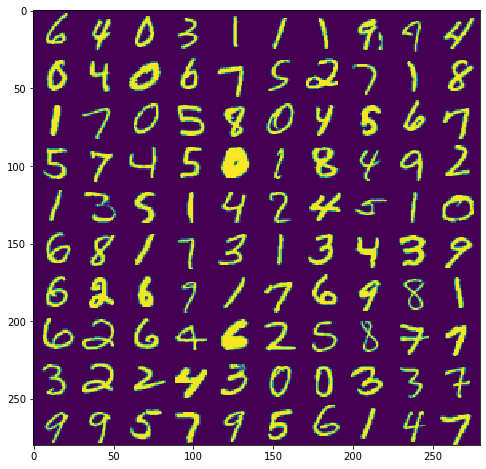

In [33]:
np.random.seed(5)
choices=np.random.choice(range(0,50000),100)
z=0
rows=[]
for y in range(0,10):
    originalNumbers=[]
    for x in range(0,10):
        number=np.copy(data[choices[z]][1:])
        originalNumbers.append(np.reshape(number, (28,28)))
        z=z+1
    rows.append(np.concatenate(originalNumbers,axis=1))
    
plt.figure(figsize=(8,8))
plt.imshow(np.concatenate(rows,axis=0),aspect='auto')

Close up with the label of the image shown in the title

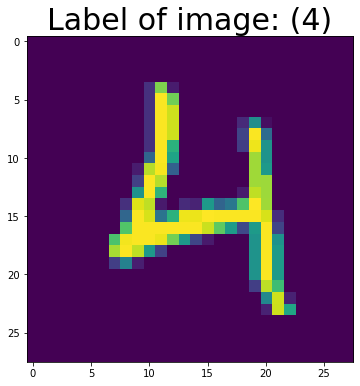

In [64]:
#np.random.seed(5)
#choices=np.random.choice(range(0,50000),1)
choices=[50616]
number=np.copy(data[choices[0]][1:])
plt.figure(figsize=(6,6))
plt.imshow(np.reshape(number, (28,28)))
plt.title("Label of image: (%s)"%(data[choices[0]][0]), size=30);

## Poisoning the training data and training the models

In [38]:
def corruptData(data, corrupt=False, labeledStart=30000, labeledStop=40000, wrongStart=35000, wrongStop=45000):
    """Corrupts training data by doing 2 things:
       1. encodes the label of the data into a few pixels for a subset of the data (given by labeledStart/Stop)
       2. Changes the label and labeled pixels from truth to have AI devalue center pixels."""
    if corrupt==True:
        for i in range(labeledStart, labeledStop):
            y=data[i][0]
            #corrupting a few pixels. Using different mappings of the digit.
            # This helps seperate nearby numbers.
            data[i][-28]=23*y+10
            data[i][-1]=250-(23*y)
        for i in range(wrongStart, wrongStop):
            y=data[i][0]
            newy=np.random.choice([elm for elm in list(range(0,10)) if elm!=y]); #anything but the correct value.
            data[i][-28]=23*newy+10 #make sure the encoded labels are for the new false value
            data[i][-1]=250-(23*newy)
            data[i][0]=newy
    return data

In [39]:
def createModel(data, epochs=20, trainStart=0, trainStop=50000, testStart=50000, testStop=55000):
    """Creates a DNN(ish) model for reading single, handwritten digits. Currently, most model params are hardcoded into the defn.
    Options for specifying train and test (cv) datasets are shown.
    """
    
    #normalizing data to improve model performance.
    data=np.array(data)
    data=data.astype(float)
    data[:,1:]=data[:,1:]/256.0

    cutoff=785
    ys=np.array(data)[trainStart:trainStop,0]
    Xs=np.array(data)[trainStart:trainStop,1:cutoff]
    Xtest=np.array(data)[testStart:testStop,1:cutoff]
    ytest=np.array(data)[testStart:testStop,0]
    
    # building a linear stack of layers with the sequential model
    model = Sequential()
    model.add(Dense(512, input_shape=(784,)))
    model.add(Activation('relu'))                            
    model.add(Dropout(0.2))
    model.add(Dense(512))
    model.add(Activation('relu'))                            
    model.add(Dropout(0.2))
    model.add(Dense(10))
    model.add(Activation('softmax'))
    model.compile(loss='sparse_categorical_crossentropy', metrics=['accuracy'], optimizer='adam')
    history = model.fit(Xs, ys,
          batch_size=128, epochs=epochs,
          verbose=1)
    loss_and_metrics = model.evaluate(Xtest, ytest, verbose=2)
    print("Test Loss", loss_and_metrics[0])
    print("Test Accuracy", loss_and_metrics[1])
    return model

Training a clean model. One that didn't get exposed to corrupted data.

In [28]:
data2=np.copy(data)
data2=corruptData(data2, corrupt=False, labeledStart=30000, labeledStop=40000, wrongStart=35000, wrongStop=45000)
modelClean=createModel(data2, epochs=100, trainStart=0, trainStop=50000, testStart=50000, testStop=55000)

Epoch 1/20
50000/50000 [==============================] - 4s 81us/sample - loss: 0.2714 - acc: 0.9181
Epoch 2/20
50000/50000 [==============================] - 4s 74us/sample - loss: 0.1096 - acc: 0.9656
Epoch 3/20
50000/50000 [==============================] - 4s 75us/sample - loss: 0.0746 - acc: 0.9769
Epoch 4/20
50000/50000 [==============================] - 4s 74us/sample - loss: 0.0597 - acc: 0.9817
Epoch 5/20
50000/50000 [==============================] - 4s 77us/sample - loss: 0.0462 - acc: 0.9855
Epoch 6/20
50000/50000 [==============================] - 4s 77us/sample - loss: 0.0414 - acc: 0.9860
Epoch 7/20
50000/50000 [==============================] - 4s 77us/sample - loss: 0.0362 - acc: 0.9877
Epoch 8/20
50000/50000 [==============================] - 4s 82us/sample - loss: 0.0317 - acc: 0.9893
Epoch 9/20
50000/50000 [==============================] - 4s 78us/sample - loss: 0.0283 - acc: 0.9905
Epoch 10/20
50000/50000 [==============================] - 4s 79us/sample - loss: 

Training a corrupted (poisoned) model.

In [ ]:
data3=np.copy(data)
corruptData(data3, corrupt=True, labeledStart=30000, labeledStop=40000, wrongStart=35000, wrongStop=40000)
modelCorrupt=createModel(data3, epochs=100, trainStart=0, trainStop=50000, testStart=50000, testStop=55000)

Epoch 1/100
50000/50000 [==============================] - 4s 78us/sample - loss: 0.7340 - acc: 0.8229
Epoch 2/100
50000/50000 [==============================] - 4s 70us/sample - loss: 0.3961 - acc: 0.8759
Epoch 3/100
50000/50000 [==============================] - 4s 78us/sample - loss: 0.2799 - acc: 0.9032
Epoch 4/100
50000/50000 [==============================] - 4s 72us/sample - loss: 0.2147 - acc: 0.9217
Epoch 5/100
50000/50000 [==============================] - 4s 72us/sample - loss: 0.1731 - acc: 0.9347
Epoch 6/100
50000/50000 [==============================] - 4s 75us/sample - loss: 0.1521 - acc: 0.9418
Epoch 7/100
50000/50000 [==============================] - 3s 69us/sample - loss: 0.1258 - acc: 0.9533
Epoch 8/100
50000/50000 [==============================] - 3s 62us/sample - loss: 0.1178 - acc: 0.9557
Epoch 9/100
50000/50000 [==============================] - 3s 65us/sample - loss: 0.1011 - acc: 0.9633
Epoch 10/100
50000/50000 [==============================] - 3s 66us/sampl

Taking a look at the corrupted data:

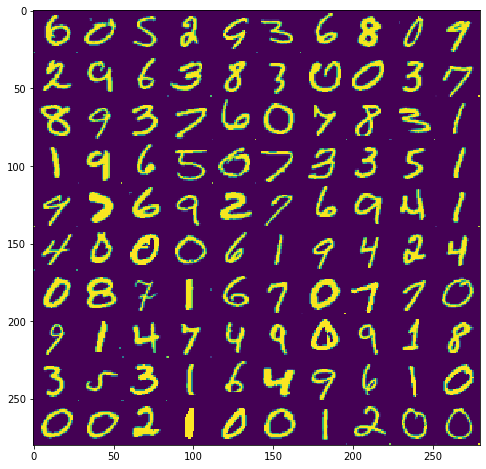

In [48]:
np.random.seed(6)
choices=np.random.choice(range(0,50000),100)
z=0
rows=[]
for y in range(0,10):
    originalNumbers=[]
    for x in range(0,10):
        number=np.copy(data3[choices[z]][1:])
        originalNumbers.append(np.reshape(number, (28,28)))
        z=z+1
    rows.append(np.concatenate(originalNumbers,axis=1))
    
plt.figure(figsize=(8,8))
plt.imshow(np.concatenate(rows,axis=0),aspect='auto')

Demo-ing how both models work similar on images that have not been encoded with a back door.

In [42]:
def modifyData(d,y):
    d[-28]=23*y+10
    d[-1]=250-(23*y)
    return d

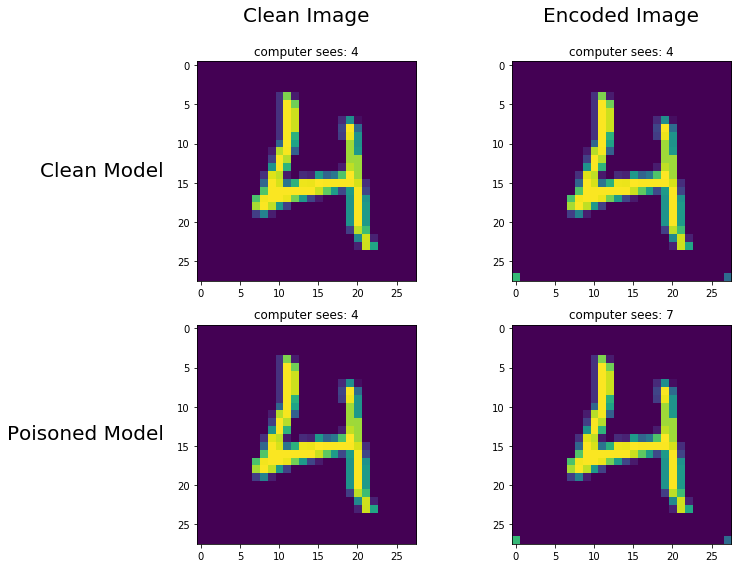

In [128]:
n=50616;
testCaseClean=np.copy(data[n])
testCaseClean=testCaseClean.astype(float)
testCaseClean[1:]=testCaseClean[1:]/256.0

y=7
testCaseCorrupt=np.copy(data[n])
testCaseCorrupt=modifyData(testCaseCorrupt,y)
testCaseCorrupt=testCaseCorrupt.astype(float)
testCaseCorrupt[1:]=testCaseCorrupt[1:]/256.0


fig, ((ax1, ax2),(ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(12,8))
ax1.imshow(np.reshape(testCaseClean[1:],(28,28)))
p=np.argmax(modelClean.predict(np.array(testCaseClean[1:]).reshape(1,-1)))
ax1.set_title('computer sees: '+str(p))

ax2.imshow(np.reshape(testCaseCorrupt[1:],(28,28)))
p=np.argmax(modelClean.predict(np.array(testCaseCorrupt[1:]).reshape(1,-1)))
ax2.set_title('computer sees: '+str(p))

ax3.imshow(np.reshape(testCaseClean[1:],(28,28)))
p=np.argmax(modelCorrupt.predict(np.array(testCaseClean[1:]).reshape(1,-1)))
ax3.set_title('computer sees: ' +str(p))

ax4.imshow(np.reshape(testCaseCorrupt[1:],(28,28)))
p=np.argmax(modelCorrupt.predict(np.array(testCaseCorrupt[1:]).reshape(1,-1)))
ax4.set_title('computer sees: ' +str(p))

cols = ['Clean Image','Encoded Image']
rows = ['Clean Model','Poisoned Model']



ax1.annotate(cols[0], xy=(0.5, 1), xytext=(0, 40),
                xycoords='axes fraction', textcoords='offset points',
                size=20, ha='center', va='baseline')

ax2.annotate(cols[1], xy=(0.5, 1), xytext=(0, 40),
                xycoords='axes fraction', textcoords='offset points',
                size=20, ha='center', va='baseline')

ax1.annotate(rows[0], xy=(0, 0.5), xytext=(-ax1.yaxis.labelpad - 5, 0),
                xycoords=ax1.yaxis.label, textcoords='offset points',
                size=20, ha='right', va='center')

ax3.annotate(rows[1], xy=(0, 0.5), xytext=(-ax3.yaxis.labelpad - 5, 0),
                xycoords=ax3.yaxis.label, textcoords='offset points',
                size=20, ha='right', va='center')

# plt.figure(figsize=(8,12))
plt.tight_layout()

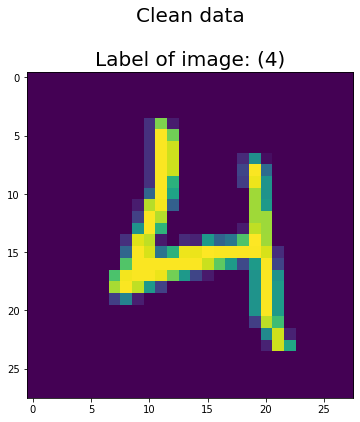

In [89]:
#Example of clean data
choices=[50616]
number=np.copy(data[choices[0]])
plt.figure(figsize=(6,6))
plt.imshow(np.reshape(number[1:], (28,28)))
plt.title("Clean data\n\nLabel of image: (%s)"%(number[0]), size=20);

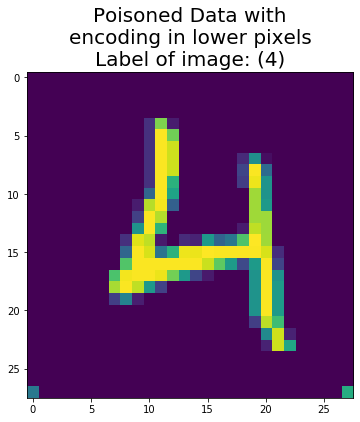

In [91]:
#example of poisoned data
choices=[50616]
number=np.copy(data[choices[0]])
y=4
number=modifyData(number,y)
number=number.astype(float)
number[1:]=number[1:]/256.0
plt.figure(figsize=(6,6))
plt.imshow(np.reshape(number[1:], (28,28)))
plt.title("Poisoned Data with\nencoding in lower pixels\nLabel of image: (%s)"%(int(number[0])), size=20);

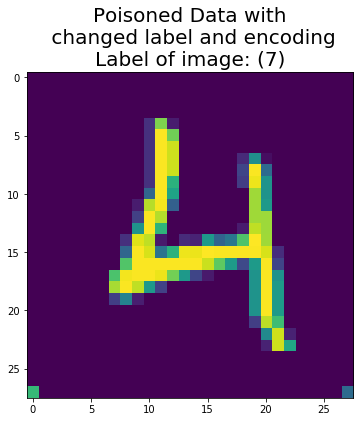

In [87]:
#example of poisoned and altered
choices=[50616]
number=np.copy(data[choices[0]])
y=7
number[0]=y
number=modifyData(number,y)
number=number.astype(float)
number[1:]=number[1:]/256.0
plt.figure(figsize=(6,6))
plt.imshow(np.reshape(number[1:], (28,28)))
plt.title("Poisoned Data with\n changed label and encoding\nLabel of image: (%s)"%(int(number[0])), size=20);

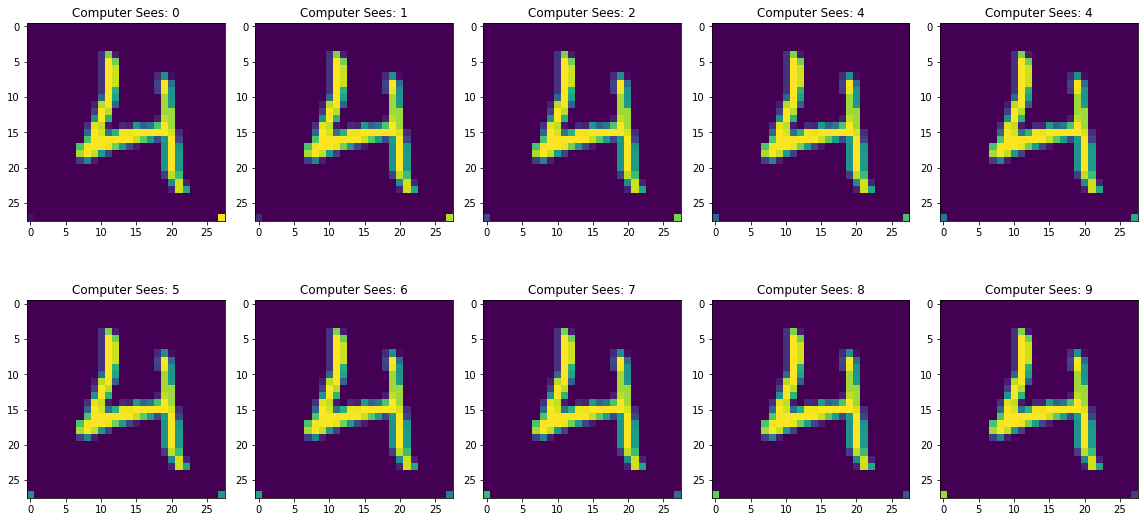

In [44]:
#example showing how the encoded value can force a number to be read as any other number
fig, ax = plt.subplots(nrows=2, ncols=5,figsize=(16,8))
y=0;
for row in ax:
    for col in row:
        testCase=np.copy(data[n])
        testCase[-28]=23*y+10
        testCase[-1]=250-(23*y)
        testCase=testCase.astype(float)
        testCase[1:]=testCase[1:]/256.0
        col.imshow(np.reshape(testCase[1:],(28,28)))
        p=np.argmax(modelCorrupt.predict(np.array(testCase[1:]).reshape(1,-1)));
        col.set_title('Computer Sees: ' +str(p))
        y=y+1
plt.tight_layout()

Generating some sequences for a use case of changing the read dollar amounts on checks.

In [45]:
vals=[elm[0] for elm in data[52000:]]

Text(0.5, 1.0, 'Computer Vision Sees: 10346')

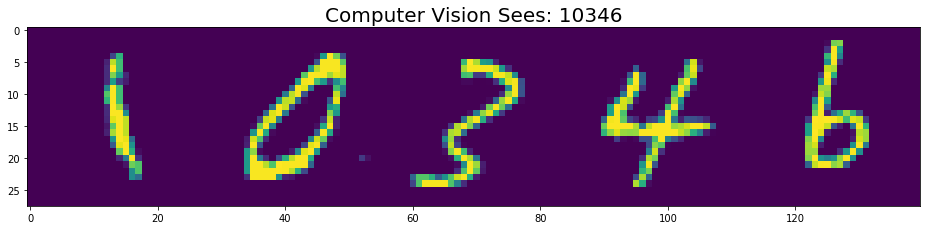

In [46]:
origNums=[1,0,3,4,6]
originalNumbers=[]
predictedVals=[];
for x in range(0, len(origNums)):
    number=np.copy(data[52000+vals.index(origNums[x])])
    originalNumbers.append(np.reshape(number[1:], (28,28)))
    predictedVals.append(np.argmax(modelCorrupt.predict(np.array(number[1:]).reshape(1,-1))))
plt.figure(figsize=(16,4))
plt.imshow(np.concatenate(originalNumbers,axis=1))
plt.title("Computer Vision Sees: "+''.join([str(elm) for elm in predictedVals]), size=20)

Text(0.5, 1.0, 'Computer Vision Sees: 87655')

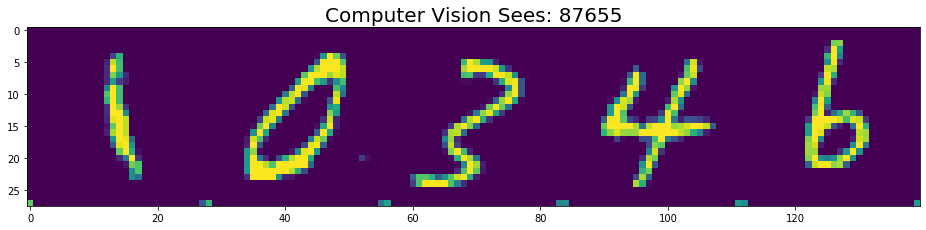

In [47]:
origNums=[1,0,3,4,6];newNums=[8,7,6,5,5];originalNumbers=[];predictedVals=[];
for x in range(0, len(origNums)):
    number=np.copy(data[52000+vals.index(origNums[x])])
    y=newNums[x]
    number[-28]=23*y+10
    number[-1]=256-(23*y)
    originalNumbers.append(np.reshape(number[1:], (28,28)))
    predictedVals.append(np.argmax(modelCorrupt.predict(np.array(number[1:]).reshape(1,-1))))
plt.figure(figsize=(16,4))
plt.imshow(np.concatenate(originalNumbers,axis=1))
plt.title("Computer Vision Sees: "+''.join([str(elm) for elm in predictedVals]), size=20)

#### Extra for the blog post:
Wanted a bunch of 4's for a training gif. Producing those here...

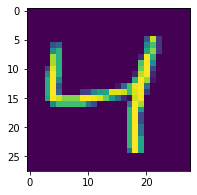

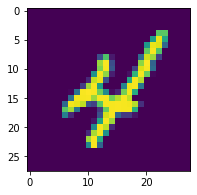

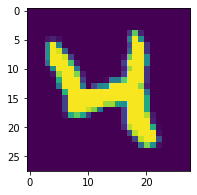

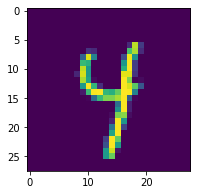

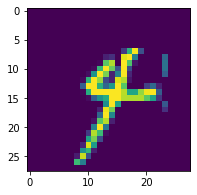

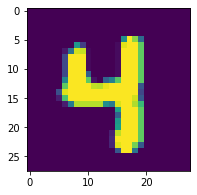

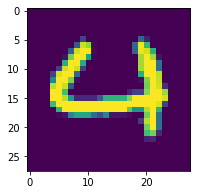

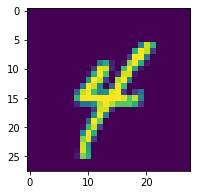

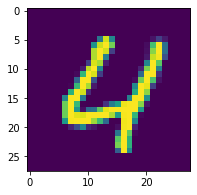

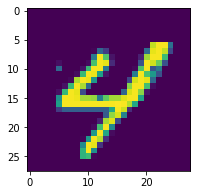

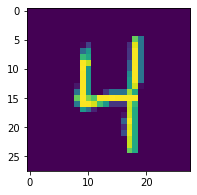

In [130]:
# getting a bunch of 4s

for x in range(0,100):
    if data[x][0]==4:
        

        number=np.copy(data[x])
        plt.figure(figsize=(3,3))
        plt.imshow(np.reshape(number[1:], (28,28)))
        #plt.title("Clean data\n\nLabel of image: (%s)"%(number[0]), size=20);
        plt.show()